In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [74]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [75]:
# Initialize objects and variables
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"
pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=10)
print('Input audio:')
display(ipd.Audio(y, rate=sr))

# Use median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic, percussive = pp.apply_median_filtering(spectrogram)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print('Harmonic component:')
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print('Percussive component:')
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


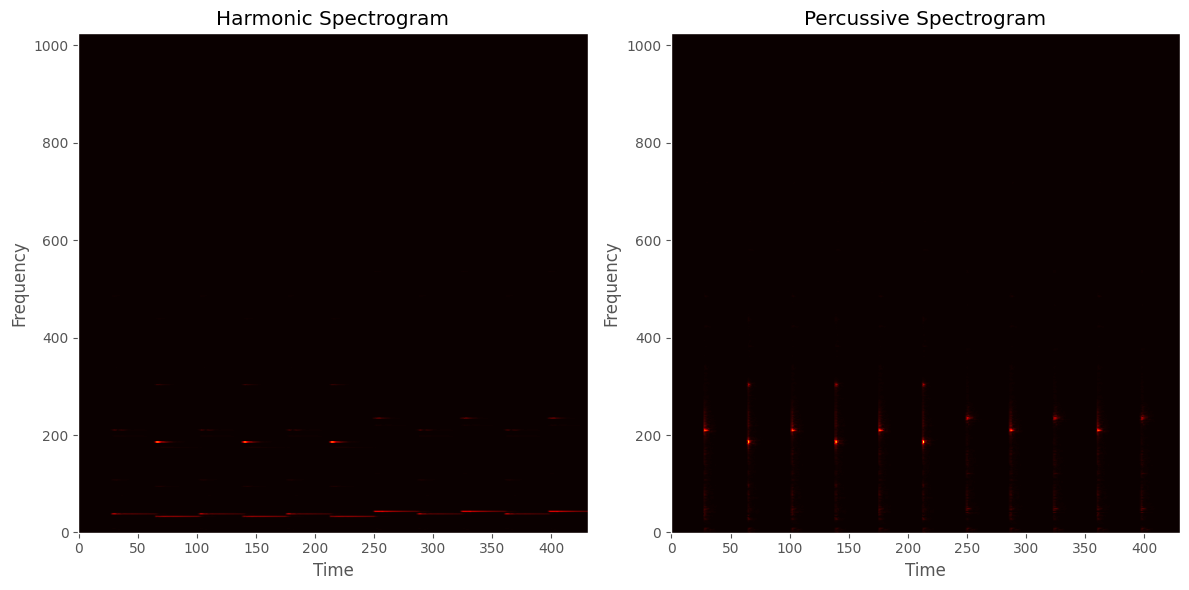

In [76]:
plt.figure(figsize=(12, 6))

# Plot harmonic spectrogram
plt.subplot(1, 2, 1)
plt.imshow(harmonic, aspect='auto', origin='lower', cmap='hot')
plt.title('Harmonic Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

# Plot percussive spectrogram
plt.subplot(1, 2, 2)
plt.imshow(percussive, aspect='auto', origin='lower', cmap='hot')
plt.title('Percussive Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.grid(False)

plt.tight_layout()
plt.show()

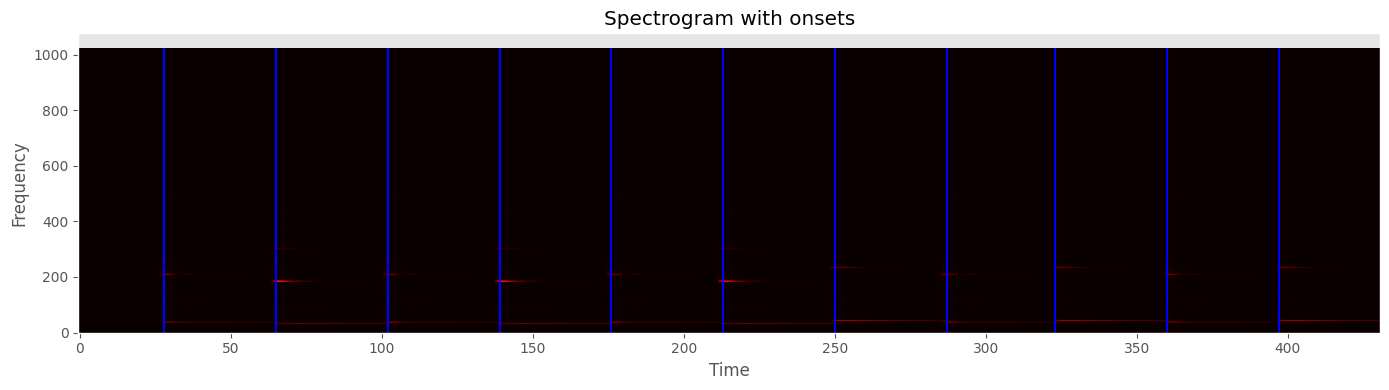

In [98]:
# Assuming you have already computed 'percussive_audio', 'sr', and 'spectrogram'

onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='hot')

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color='blue', linestyle='-')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title('Spectrogram with onsets')

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

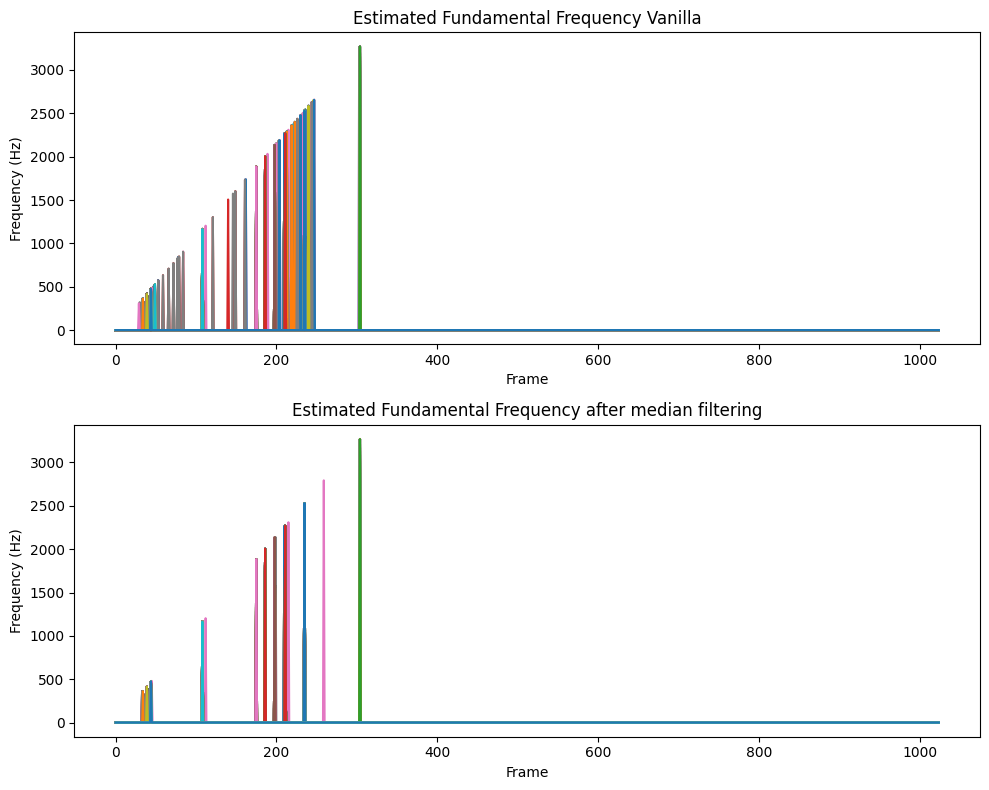

In [11]:
# activations = pp.apply_NMF(spectrogram)
pitches, magnitudes = pitch_est.estimate_dsp(spectrogram, sr)

harm_pitches, harm_magnitudes = pitch_est.estimate_dsp(harmonic, sr)

plt.figure(figsize=(10, 8))

# Plotting the first subplot
plt.subplot(2, 1, 1)
plt.plot(pitches)
plt.xlabel('Frame')
plt.ylabel('Frequency (Hz)')
plt.title('Estimated Fundamental Frequency Vanilla')

# Plotting the second subplot
plt.subplot(2, 1, 2)
plt.plot(harm_pitches)
plt.xlabel('Frame')
plt.ylabel('Frequency (Hz)')
plt.title('Estimated Fundamental Frequency after median filtering')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



Filtered Frequencies:


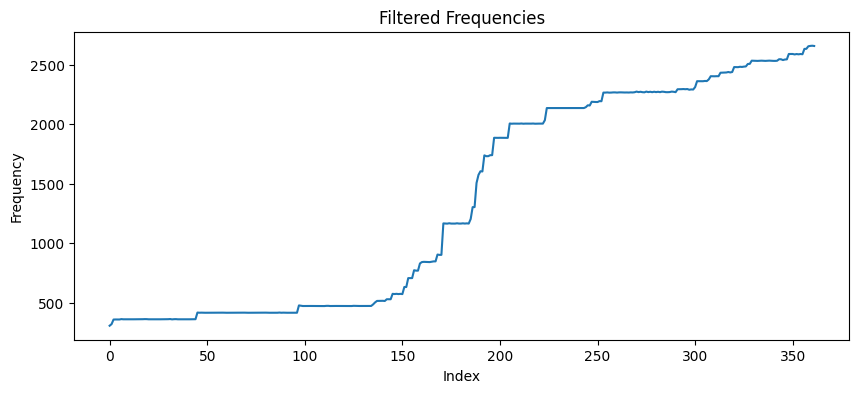

In [12]:

# Set the threshold for discarding very low or very high frequencies
threshold_low = 90  # Minimum frequency threshold
threshold_high = 3000  # Maximum frequency threshold

# Flatten the pitches array to make it 1-dimensional
pitches_flat = pitches.flatten()

# Find the peaks in the pitches
peaks, _ = scipy.signal.find_peaks(pitches_flat)

# Filter the peaks based on the threshold
filtered_peaks = [peak for peak in peaks if threshold_low <= pitches_flat[peak] <= threshold_high]

# Get the frequencies of the filtered peaks
filtered_frequencies = pitches_flat[filtered_peaks]

# Display the filtered frequencies
print("Filtered Frequencies:")
plt.figure(figsize=(10, 4))
plt.plot(filtered_frequencies)
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Filtered Frequencies')
plt.show()

In [14]:
time, frequency, confidence, activation = pitch_est.estimate_crepe(harmonic_audio, sr)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


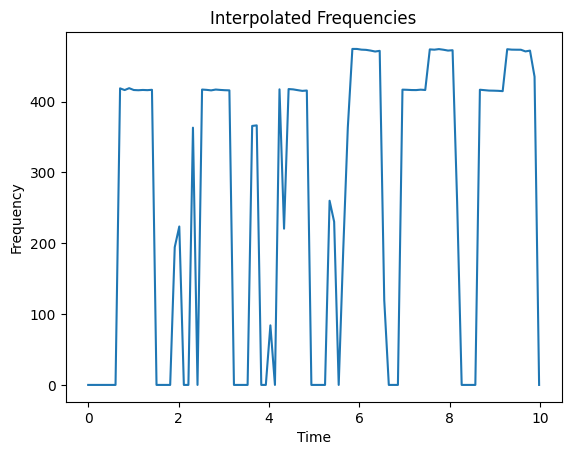

In [8]:
frequency[confidence < 0.9] = 0

# Create a function to interpolate the frequencies
interpolated_frequency = scipy.interpolate.interp1d(time, frequency, kind='linear')

# Generate a new set of time values for smoother lines
new_time = np.linspace(time.min(), time.max(), num=100)

# Interpolate the frequencies using the new time values
new_frequency = interpolated_frequency(new_time)

# Plot the interpolated frequencies
plt.plot(new_time, new_frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Interpolated Frequencies')
plt.show()